
Loaded: (202, 33) rows × columns


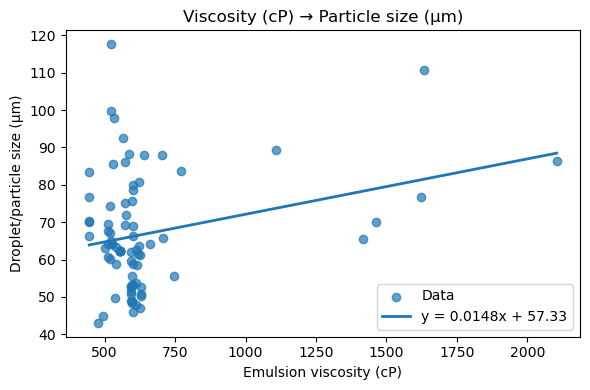

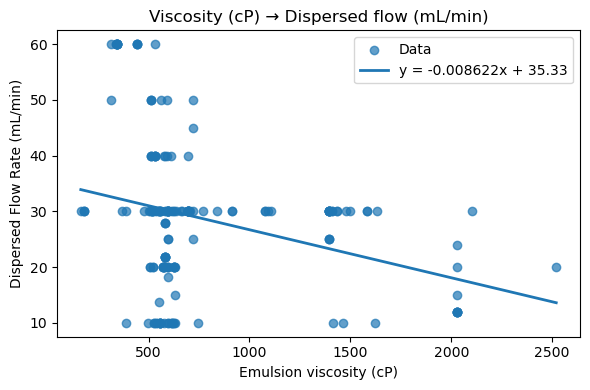

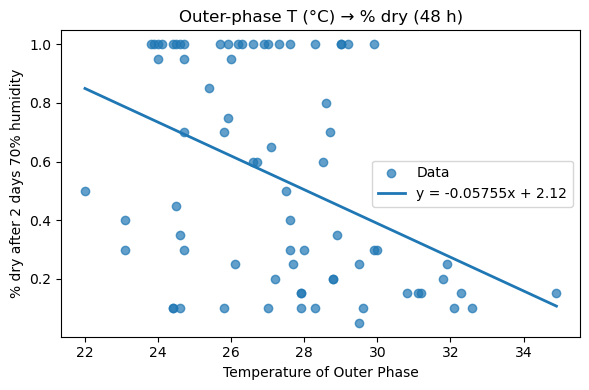


===== Regression summary =====
              Relationship                 n    Slope     R²     p-value
     Viscosity (cP) → Particle size (µm)  80    0.0148 0.07483   0.01408
Viscosity (cP) → Dispersed flow (mL/min) 188 -0.008622 0.08794 3.592e-05
       Outer-phase T (°C) → % dry (48 h)  74  -0.05755  0.1691  0.000273


In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Emulsion-process EDA:
  ─ Emulsion viscosity  vs  Particle size
  ─ Emulsion viscosity  vs  Dispersed flow rate
  ─ Outer-phase temperature  vs  %-dry (48 h)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress   # use sklearn if you prefer

# ── 0. CONFIG ────────────────────────────────────────────────────────────────
file_path = r"C:\Users\HP\Downloads\AXF-1 data update 29APR25.xlsx"  
sheet      = "Raw Data"                       # sheet name in the workbook
z_thresh   = 3                                # outlier cut-off (z-score)

pairs = {
    "Viscosity (cP) → Particle size (µm)": (
        "Emulsion viscosity (cP)",
        "Droplet/particle size (µm)"
    ),
    "Viscosity (cP) → Dispersed flow (mL/min)": (
        "Emulsion viscosity (cP)",
        "Dispersed Flow Rate (mL/min)"
    ),
    "Outer-phase T (°C) → % dry (48 h)": (
        "Temperature of Outer Phase",
        "% dry after 2 days 70% humidity"
    ),
}

# ── 1. LOAD DATA ─────────────────────────────────────────────────────────────
df = pd.read_excel(file_path, sheet_name=sheet)

# Optional: show a quick data snapshot
print("\nLoaded:", df.shape, "rows × columns")

# ── 2. HELPER: simple z-score outlier removal ───────────────────────────────
def z_filter(frame: pd.DataFrame, threshold: float = 3.0) -> pd.DataFrame:
    """Drop rows where any column is > |threshold| standard deviations."""
    z = (frame - frame.mean()) / frame.std(ddof=0)
    return frame[(np.abs(z) < threshold).all(axis=1)]

# ── 3. LOOP THROUGH EACH RELATIONSHIP ───────────────────────────────────────
stats_rows = []

for title, (xcol, ycol) in pairs.items():
    # 3.1  isolate and clean
    sub = df[[xcol, ycol]].apply(pd.to_numeric, errors="coerce").dropna()
    sub = z_filter(sub, z_thresh)
    if sub.empty:
        print(f"\n[WARN] No valid data for: {title}")
        continue

    X = sub[xcol].values
    y = sub[ycol].values

    # 3.2  regression
    slope, intercept, r_val, p_val, stderr = linregress(X, y)
    r2 = r_val ** 2
    stats_rows.append({
        "Relationship": title,
        "n": len(sub),
        "Slope": slope,
        "R²": r2,
        "p-value": p_val
    })

    # 3.3  plot
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, alpha=0.7, label="Data")
    xs = np.linspace(X.min(), X.max(), 100)
    plt.plot(xs, intercept + slope * xs, linewidth=2,
             label=f"y = {slope:.4g}x + {intercept:.2f}")
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ── 4. PRINT SUMMARY TABLE ──────────────────────────────────────────────────
summary = pd.DataFrame(stats_rows)
print("\n===== Regression summary =====")
print(summary.to_string(index=False, justify="center", float_format="%.4g"))



🗂  Dataset dimensions: 202 rows × 33 columns

🔎  dtypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Column 1                           202 non-null    object        
 1   Date of experiment                 202 non-null    datetime64[ns]
 2   Aims & Hypothesis                  201 non-null    object        
 3   Core used                          202 non-null    object        
 4   Core Formulation                   202 non-null    object        
 5   Core Viscosity (cP)                193 non-null    float64       
 6   UV used                            202 non-null    object        
 7   UV formulation                     202 non-null    object        
 8   UV viscosity (cP)                  197 non-null    float64       
 9   Emulsion viscosity (cP)        

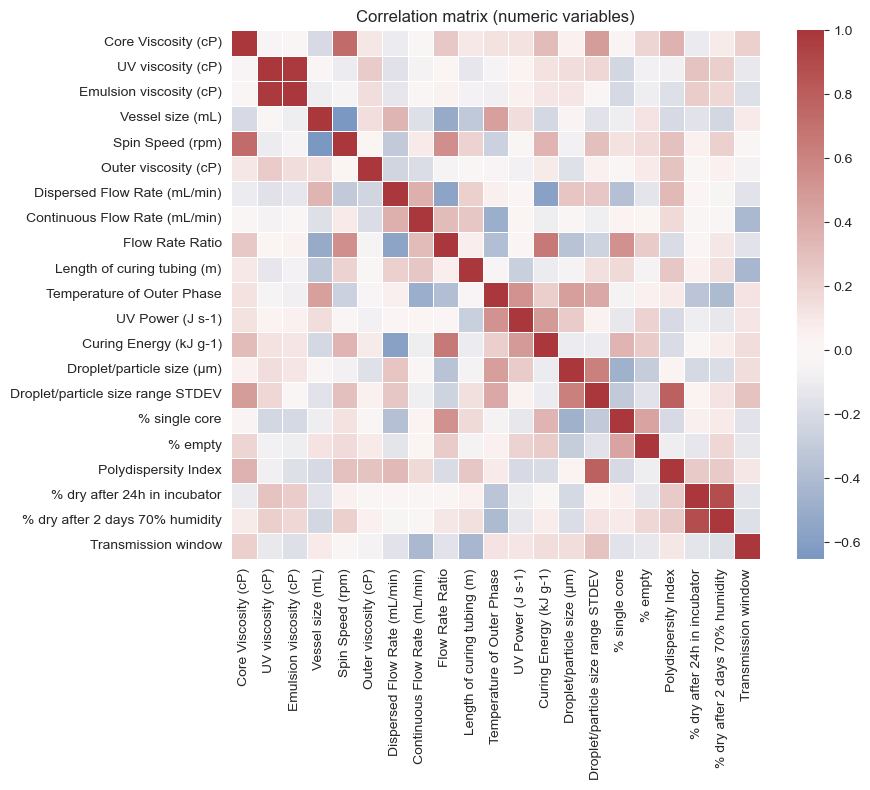

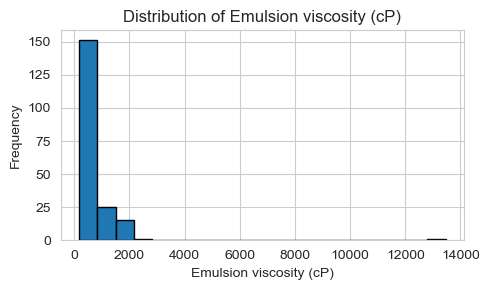

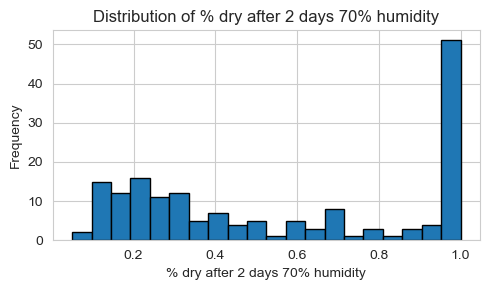

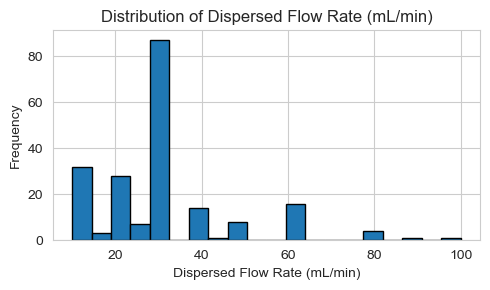

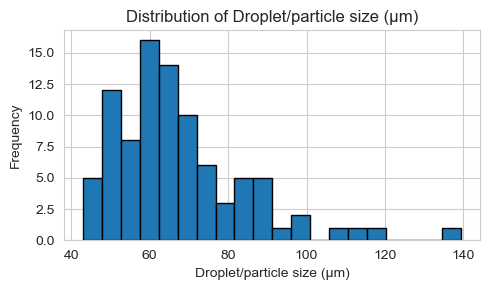

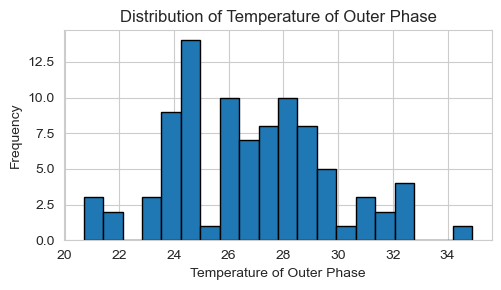

In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
AXF-1  •  Exploratory Data Analysis
----------------------------------
• Loads the “Raw Data” sheet
• Summarises dataset structure (rows, columns, dtypes)
• Builds missing-value table, numeric descriptive stats
• Creates a correlation heat-map + histograms of key variables
"""

# ── 0. Imports ──────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
sns.set_style("whitegrid")       # nice default look

# ── 1. Locate the workbook ─────────────────────────────────────────────────
# Choose ONE of the three styles ↓↓↓

# A) RAW STRING  (quick fix)
file_path = r"C:\Users\HP\Downloads\AXF-1 data update 29APR25.xlsx"

# B) FORWARD SLASHES  (also safe on Windows)
# file_path = "C:/Users/HP/Downloads/AXF-1 data update 29APR25.xlsx"

# C) pathlib  (portable & robust)
# file_path = Path.home() / "Downloads" / "AXF-1 data update 29APR25.xlsx"

# ── 2. Load the “Raw Data” sheet ───────────────────────────────────────────
df = pd.read_excel(file_path, sheet_name="Raw Data")

# ── 3. Dataset structure ───────────────────────────────────────────────────
print("\n🗂  Dataset dimensions:", df.shape[0], "rows ×", df.shape[1], "columns\n")
print("🔎  dtypes and non-null counts:")
df.info(show_counts=True)          # includes dtype, non-null counts

# Optional: view the first few lines
# display(df.head())

# ── 4. Missing-value summary ───────────────────────────────────────────────
missing_tbl = (
    df.isna().sum()
      .to_frame("Missing_Count")
      .query("Missing_Count > 0")
      .assign(Missing_Percent=lambda s: (100 * s.Missing_Count / len(df)).round(1))
      .sort_values("Missing_Count", ascending=False)
)
print("\n🚨  Columns with missing data (non-zero only):")
print(missing_tbl.to_markdown())

# ── 5. Descriptive statistics for numeric fields ───────────────────────────
num_stats = df.select_dtypes(include=np.number).describe().T
print("\n📊  Descriptive statistics (numeric):")
print(num_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# ── 6. Correlation matrix & heat-map ───────────────────────────────────────
num_df = df.select_dtypes(include=np.number)
corr = num_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="vlag", center=0, linewidths=.5, square=True)
plt.title("Correlation matrix (numeric variables)")
plt.tight_layout()
plt.show()

# ── 7. Histograms of key process variables ────────────────────────────────
key_cols = {
    "Emulsion viscosity (cP)",
    "Droplet/particle size (µm)",
    "Dispersed Flow Rate (mL/min)",
    "Temperature of Outer Phase",
    "% dry after 2 days 70% humidity"
}

for col in key_cols & set(df.columns):      # only plot if column exists
    data = pd.to_numeric(df[col], errors="coerce").dropna()
    plt.figure(figsize=(5, 3))
    plt.hist(data, bins=20, edgecolor="black")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# ── 8. Optional: pair-plot for a quick multivariate glance ─────────────────
# sns.pairplot(df[list(key_cols & set(df.columns))], corner=True)
# plt.show()


📘 Regression: Droplet/particle size (µm) ~ Emulsion viscosity (cP)
                                OLS Regression Results                                
Dep. Variable:     Droplet/particle size (µm)   R-squared:                       0.075
Model:                                    OLS   Adj. R-squared:                  0.063
Method:                         Least Squares   F-statistic:                     6.308
Date:                        Wed, 07 May 2025   Prob (F-statistic):             0.0141
Time:                                17:01:17   Log-Likelihood:                -327.59
No. Observations:                          80   AIC:                             659.2
Df Residuals:                              78   BIC:                             663.9
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                              coef    std err          t      

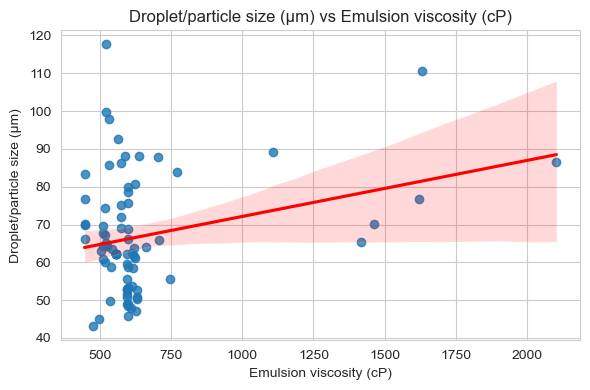

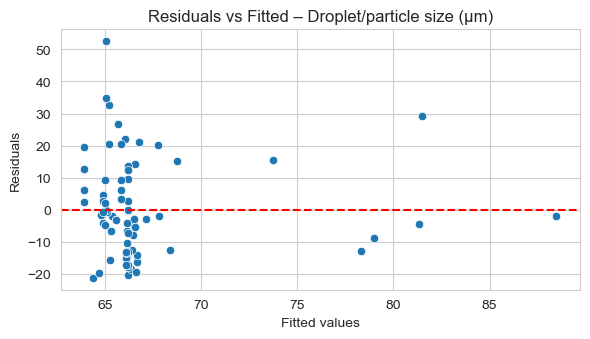


📘 Regression: Dispersed Flow Rate (mL/min) ~ Emulsion viscosity (cP)
                                 OLS Regression Results                                 
Dep. Variable:     Dispersed Flow Rate (mL/min)   R-squared:                       0.088
Model:                                      OLS   Adj. R-squared:                  0.083
Method:                           Least Squares   F-statistic:                     17.93
Date:                          Wed, 07 May 2025   Prob (F-statistic):           3.59e-05
Time:                                  17:01:18   Log-Likelihood:                -744.20
No. Observations:                           188   AIC:                             1492.
Df Residuals:                               186   BIC:                             1499.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                              coef    st

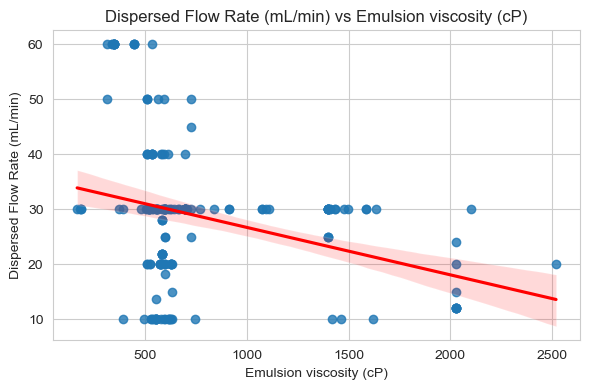

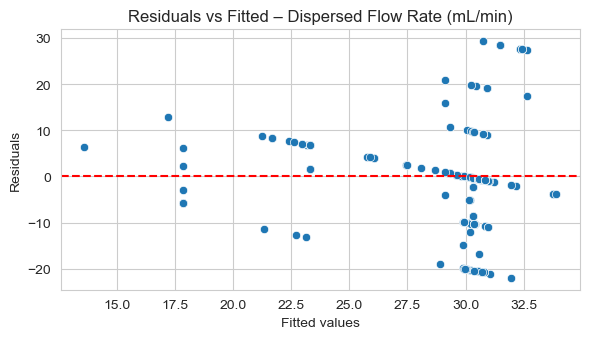


📘 Regression: % dry after 2 days 70% humidity ~ Temperature of Outer Phase
                                   OLS Regression Results                                  
Dep. Variable:     % dry after 2 days 70% humidity   R-squared:                       0.169
Model:                                         OLS   Adj. R-squared:                  0.158
Method:                              Least Squares   F-statistic:                     14.65
Date:                             Wed, 07 May 2025   Prob (F-statistic):           0.000273
Time:                                     17:01:19   Log-Likelihood:                -23.987
No. Observations:                               74   AIC:                             51.97
Df Residuals:                                   72   BIC:                             56.58
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
    

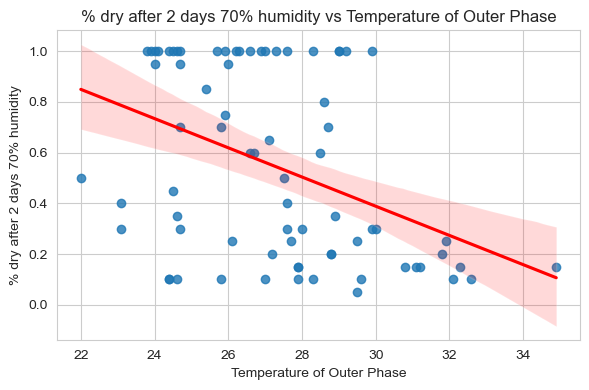

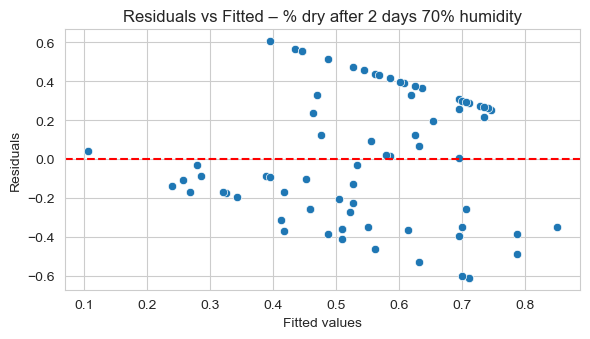

In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ── Load Excel File ───────────────────────────────────────────────
file_path = Path(r"C:\Users\HP\Downloads\AXF-1 data update 29APR25.xlsx")  # adjust path if needed
df = pd.read_excel(file_path, sheet_name="Raw Data")

# ── Define relationships to model ─────────────────────────────────
models = {
    "Droplet/particle size (µm)": "Emulsion viscosity (cP)",
    "Dispersed Flow Rate (mL/min)": "Emulsion viscosity (cP)",
    "% dry after 2 days 70% humidity": "Temperature of Outer Phase"
}

# ── Run and interpret regression for each pair ─────────────────────
for target, predictor in models.items():
    data = df[[predictor, target]].apply(pd.to_numeric, errors='coerce').dropna()

    # Remove extreme outliers
    z = (data - data.mean()) / data.std()
    data = data[(np.abs(z) < 3).all(axis=1)]

    X = sm.add_constant(data[predictor])  # add intercept
    y = data[target]

    model = sm.OLS(y, X).fit()
    print(f"\n📘 Regression: {target} ~ {predictor}")
    print(model.summary())

    # ── Plot regression with 95% CI ────────────────────────────────
    plt.figure(figsize=(6, 4))
    sns.regplot(x=predictor, y=target, data=data, ci=95, line_kws={"color": "red"})
    plt.title(f"{target} vs {predictor}")
    plt.xlabel(predictor)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

    # ── Plot residuals vs fitted ───────────────────────────────────
    residuals = model.resid
    fitted = model.fittedvalues

    plt.figure(figsize=(6, 3.5))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Residuals vs Fitted – {target}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()